# Agrupamento de Dados
## Aplicação em NLP -- Agrupamento de Notícias da BBC

Nathan Siegle Hartmann<br/>
https://www.linkedin.com/in/nathan-siegle-hartmann

Material disponível em https://github.com/nathanshartmann/agrupamento_nlp_exemplo

-----

<img src="../data/img/capa.jpg">

-----

# Vamos começar carregando as notícias da BBC
http://mlg.ucd.ie/datasets/bbc.html
#### 2.225 notícias do site BBC entre os anos de 2004 e 2005
#### 5 categorias
* Business
* Entertainment
* Politics
* Sport
* Tech

In [1]:
from os import listdir
!mkdir ../data/
if 'bbc' not in listdir('../data'):
    !wget -qO- http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip | bsdtar -xvf-
    !mv bbc ../data/

mkdir: ../data/: File exists


In [2]:
def get_titles(category):
    """Get titles from bbc dump files."""
    
    from os import path, listdir
    import codecs
    titles = []
    cat_dir = '../data/bbc/{category}/'.format(category=category)
    for file in listdir(cat_dir):
        try:
            with codecs.open(path.join(cat_dir, file), encoding='utf-8') as fp:
                titles.append(fp.read().splitlines()[0])
        except:
            with codecs.open(path.join(cat_dir, file), encoding='latin-1') as fp:
                titles.append(fp.read().splitlines()[0])
    return titles

categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

import pandas as pd
df = pd.DataFrame()
for category in categories:
    titles = get_titles(category)
    df_aux = pd.DataFrame(titles, columns=['title'])
    df_aux['category'] = category
    df = df.append(df_aux)

# Distribuição de notícias por categoria

In [3]:
from IPython.display import display
df.shape
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

# Exemplo do dataframe

In [4]:
df.sample(n=5, random_state=42)

,title,category
414,McDonald's boss Bell dies aged 44,business
420,Diageo to buy US wine firm,business
331,Mourinho to escape FA charge,sport
416,AstraZeneca hit by drug failure,business
336,Sport betting rules in spotlight,politics


# Qual o vocabulário que compõe cada categoria?

business


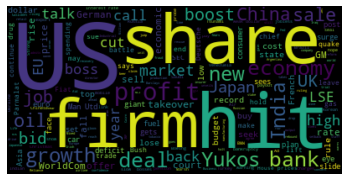

entertainment


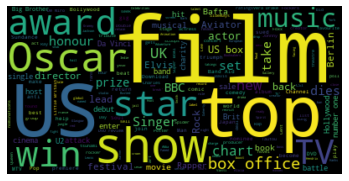

politics


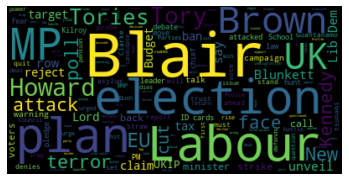

sport


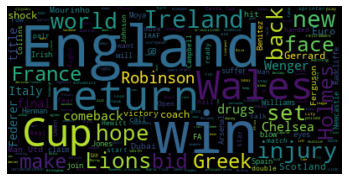

tech


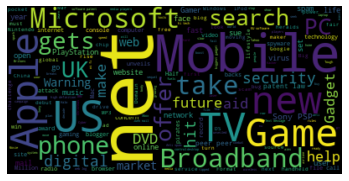

In [5]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools

wordcloud = WordCloud(max_words=200,
                      normalize_plurals=True)

for cat in df['category'].unique():
    print(cat)
    text = ' '.join(df.loc[df['category']==cat]['title'].values)

    plt.imshow(wordcloud.generate(text), interpolation='bilinear')
    plt.axis("off")
    plt.show()

-----
# Modelagem

### Abordagem tradicional?

<img src="../data/img/tfidf.png">

* Vocabulário limitado
* Trabalha no formato bag-of-words
* Não captura semântica

-----
# Word Embeddings

#### Word2Vec
###### Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. 2013. Distributed representations of words and phrases and their compositionality. 

<img src="../data/img/word2vec.jpg">

<img src="../data/img/neuralnetwork_birl.jpeg">

-----
# Mas vamos usar um outro modelo de Word Embeddings
#### GloVe (Global Vectors)
###### Pennington J., Socher R., and Manning C. 2014. GloVe: Global Vectors for Word Representation

https://nlp.stanford.edu/projects/glove/
* Wikipedia 2014 + Gigaword 5 
* 6B tokens
* 400K vocab
* uncased
* 50 dimensões

<img src="../data/img/glove_equation.png">

<img src="../data/img/glove.png">

In [6]:
from os import listdir
!mkdir ../models/
if 'glove.6B.50d.txt' not in listdir('../models'):
    !wget -qO- http://nlp.stanford.edu/data/glove.6B.zip | bsdtar -xvf-
    !mv glove.6B.50d.txt ../models/
    !mv glove.6B.100d.txt ../models/
    !mv glove.6B.200d.txt ../models/
    !mv glove.6B.300d.txt ../models/
    for dim in [50, 100, 200, 300]:        
        with open('../models/glove.6b.{dim}d.txt'.format(dim=dim), 'r') as fp:
            t = fp.read()
        with open('../models/glove.6b.{dim}d.txt'.format(dim=dim), 'w') as fp:
            t = '400000 {dim}\n'.format(dim=dim) + t
            fp.write(t)
    del t

mkdir: ../models/: File exists


In [7]:
from gensim.models import KeyedVectors
emb = KeyedVectors.load_word2vec_format('../models/glove.6b.50d.txt')

# Curiosidades

<img src="../data/img/king_queen.png">

In [8]:
emb.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.8523603677749634),
 ('throne', 0.7664334177970886),
 ('prince', 0.759214460849762),
 ('daughter', 0.7473883032798767),
 ('elizabeth', 0.7460220456123352),
 ('princess', 0.7424569725990295),
 ('kingdom', 0.7337411642074585),
 ('monarch', 0.7214490175247192),
 ('eldest', 0.7184861898422241),
 ('widow', 0.7099430561065674)]

In [9]:
emb.most_similar(positive=['dad', 'woman'], negative=['man'])

[('mom', 0.9198636412620544),
 ('grandmother', 0.8510967493057251),
 ('mother', 0.8247368931770325),
 ('aunt', 0.8048515915870667),
 ('girl', 0.7977524399757385),
 ('girlfriend', 0.7853891849517822),
 ('remembers', 0.7791407108306885),
 ('daughter', 0.7675017714500427),
 ('loves', 0.7586792707443237),
 ('boy', 0.7538156509399414)]

In [10]:
emb.most_similar(positive=['brazil'])

[('portugal', 0.8770194053649902),
 ('argentina', 0.8712694644927979),
 ('rica', 0.8380685448646545),
 ('spain', 0.8340149521827698),
 ('costa', 0.825968325138092),
 ('brazilian', 0.8253439664840698),
 ('peru', 0.8201212882995605),
 ('bolivia', 0.8196378350257874),
 ('uruguay', 0.8183497786521912),
 ('chile', 0.8135911226272583)]

# Word embeddings, em geral, reconhecem apenas palavras em lowercase
> Decisão para reduzir a dimensionalidade do vocabulário

In [11]:
print('king' in emb.vocab)
display(emb['king'])

True


array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ], dtype=float32)

In [12]:
print('King' in emb.vocab)

# display(emb['King'])

False


# Necessário pré-processamento dos textos
* Todas as palavras devem ser passadas para lowercase
* Vamos aproveitar e remover stopwords e pontuações

In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

stopWords = set(stopwords.words('english'))

def preprocessing(sentence):
    """Basic preprocessing function.
    
    Tokenize a sentence.
    Remove stopwords and punctuation.
    
    Return words in lowercase.
    """
    
    tokens = word_tokenize(sentence)
    wordsFiltered = [t.lower() for t in tokens if t not in stopWords and t not in punctuation]
    
    return wordsFiltered

df['title_clean'] = df['title'].apply(lambda x: preprocessing(x))

# Exemplo do novo dataframe

In [14]:
df.sample(n=5, random_state=42)

,title,category,title_clean
414,McDonald's boss Bell dies aged 44,business,"[mcdonald, 's, boss, bell, dies, aged, 44]"
420,Diageo to buy US wine firm,business,"[diageo, buy, us, wine, firm]"
331,Mourinho to escape FA charge,sport,"[mourinho, escape, fa, charge]"
416,AstraZeneca hit by drug failure,business,"[astrazeneca, hit, drug, failure]"
336,Sport betting rules in spotlight,politics,"[sport, betting, rules, spotlight]"


# Modelo ainda possui limitação com palavras desconhecidas

In [15]:
print('errou' in emb.vocab)
# display(emb['errou'])

False


# Mas Word Embeddings modelam o desconhecido
* Tokens com baixa frequência (em geral, freq<=5) são mapeados para um token "unk"
* Todo o desconhecido é mapeado para um token genérico

In [16]:
emb['unk']

array([-7.9149e-01,  8.6617e-01,  1.1998e-01,  9.2287e-04,  2.7760e-01,
       -4.9185e-01,  5.0195e-01,  6.0792e-04, -2.5845e-01,  1.7865e-01,
        2.5350e-01,  7.6572e-01,  5.0664e-01,  4.0250e-01, -2.1388e-03,
       -2.8397e-01, -5.0324e-01,  3.0449e-01,  5.1779e-01,  1.5090e-02,
       -3.5031e-01, -1.1278e+00,  3.3253e-01, -3.5250e-01,  4.1326e-02,
        1.0863e+00,  3.3910e-02,  3.3564e-01,  4.9745e-01, -7.0131e-02,
       -1.2192e+00, -4.8512e-01, -3.8512e-02, -1.3554e-01, -1.6380e-01,
        5.2321e-01, -3.1318e-01, -1.6550e-01,  1.1909e-01, -1.5115e-01,
       -1.5621e-01, -6.2655e-01, -6.2336e-01, -4.2150e-01,  4.1873e-01,
       -9.2472e-01,  1.1049e+00, -2.9996e-01, -6.3003e-03,  3.9540e-01],
      dtype=float32)

# Vamos adicionar um mapeamento genérico para tratar o vocabulário desconhecido

In [17]:
from collections import defaultdict

new_emb = defaultdict(lambda: emb['unk'])
for k, v in [(w, emb[w]) for w in emb.vocab]:
    new_emb[k] = v

In [18]:
new_emb['errou']

array([-7.9149e-01,  8.6617e-01,  1.1998e-01,  9.2287e-04,  2.7760e-01,
       -4.9185e-01,  5.0195e-01,  6.0792e-04, -2.5845e-01,  1.7865e-01,
        2.5350e-01,  7.6572e-01,  5.0664e-01,  4.0250e-01, -2.1388e-03,
       -2.8397e-01, -5.0324e-01,  3.0449e-01,  5.1779e-01,  1.5090e-02,
       -3.5031e-01, -1.1278e+00,  3.3253e-01, -3.5250e-01,  4.1326e-02,
        1.0863e+00,  3.3910e-02,  3.3564e-01,  4.9745e-01, -7.0131e-02,
       -1.2192e+00, -4.8512e-01, -3.8512e-02, -1.3554e-01, -1.6380e-01,
        5.2321e-01, -3.1318e-01, -1.6550e-01,  1.1909e-01, -1.5115e-01,
       -1.5621e-01, -6.2655e-01, -6.2336e-01, -4.2150e-01,  4.1873e-01,
       -9.2472e-01,  1.1049e+00, -2.9996e-01, -6.3003e-03,  3.9540e-01],
      dtype=float32)

# Já estamos prontos para modelar os títulos das nossas notícias
> Vamos utilizar a estratégia de soma das embeddings

#### Expectativa:
> Soma da semântica das palavras resulta na composição semântica delas

<img src="../data/img/sum_embeddings.png">

In [19]:
import numpy as np
df['title_emb'] = df['title_clean'].apply(lambda x: np.sum([new_emb[w] for w in x], axis=0))

# Exemplo do novo dataframe

In [20]:
df.sample(n=5, random_state=42)

,title,category,title_clean,title_emb
414,McDonald's boss Bell dies aged 44,business,"[mcdonald, 's, boss, bell, dies, aged, 44]","[-0.20971397, 2.157794, 1.8606832, 0.1519779, ..."
420,Diageo to buy US wine firm,business,"[diageo, buy, us, wine, firm]","[1.92766, -0.44981998, 0.43277004, 0.86868906,..."
331,Mourinho to escape FA charge,sport,"[mourinho, escape, fa, charge]","[0.96769, 0.46788004, -0.87649, 0.744835, -0.6..."
416,AstraZeneca hit by drug failure,business,"[astrazeneca, hit, drug, failure]","[2.52868, -3.343122, 0.86212003, 0.393237, -1...."
336,Sport betting rules in spotlight,politics,"[sport, betting, rules, spotlight]","[-2.3057551, -0.60058, -1.534824, 1.9462099, -..."


-----
# Finalmente!
## Vamos agrupar!!

* K-means
* Similaridade pelo cosseno 
> Usualmente a similaridade do cosseno é utilizada ao trabalhar com textos devido a esparsidade do vocabulário.

* As magnitudes são ignoradas pelo cosseno, diferentemente da euclidiana

<img src="../data/img/eucos.png">

-----
# Quantos grupos devemos gerar?

> Assumindo que não sabemos o número de categorias das nossas notícias, como escolher o número de categorias?

# Método do cotovelo (elbow)

<img src="../data/img/elbow.png">

100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


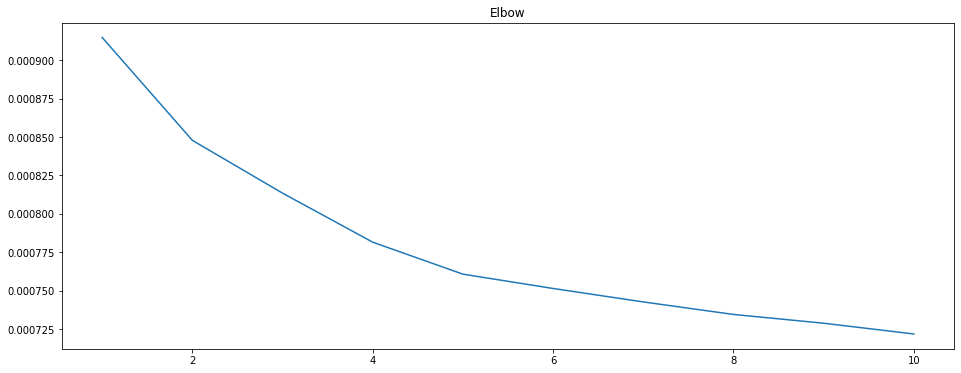

In [21]:
from nltk.cluster.kmeans import KMeansClusterer
from tqdm import tqdm
import nltk
import numpy as np
import random
random.seed(42)

square_errors = []
for k in tqdm(range(1,11)):
    kclusterer = KMeansClusterer(num_means=k,
                                 distance=nltk.cluster.util.cosine_distance,
                                 repeats=1,
                                 rng=random
                                 )
#     kclusterer = KMeansClusterer(num_means=k,
#                                  distance=nltk.cluster.util.euclidean_distance,
#                                  repeats=1)
    assigned_clusters = kclusterer.cluster(df['title_emb'], assign_clusters=True)

    sum_of_squares = 0
    current_cluster = 0
    for centroid in kclusterer.means():
        current_page = 0
        for index_of_cluster_of_page in assigned_clusters:
            if index_of_cluster_of_page == current_cluster:
                y = df['title_emb'].values[current_page]
                #sum_of_squares += np.sum((centroid - y) ** 2)
                sum_of_squares += (np.dot(centroid,y)**2)/(np.dot(centroid,centroid) * np.dot(y,y))
            current_page += 1
        current_cluster += 1

    square_errors.append(sum_of_squares)

plt.figure(figsize=(16,6))
plt.plot(range(1,11), 1/np.array(square_errors))
plt.title('Elbow')
plt.show()

# Não conseguimos identificar facilmente o cotovelo
* se é que esse cotovelo realmente existe

##### Estratégia:
> Transformamos o joelho em um pico

<img src="../data/img/peak.png">

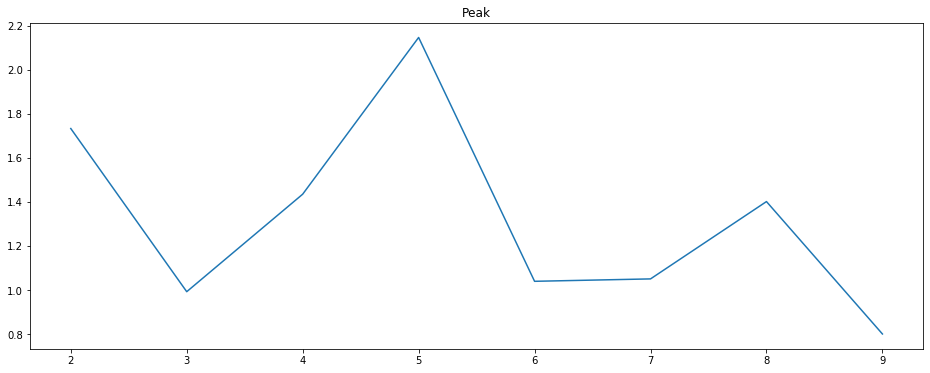

In [22]:
import numpy as np
new = [np.abs((square_errors[i-1] - square_errors[i])/(square_errors[i] - square_errors[i+1])) for i in range(1, len(square_errors)-1)]
plt.figure(figsize=(16,6))
plt.plot(range(2,10), new)
plt.title('Peak')
plt.show()

# Identificamos o pico em 5 grupos
> Vamos rodar o K-means com k=5

In [23]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer
import random
random.seed(42)
kclusterer = KMeansClusterer(num_means=5,
                             distance=nltk.cluster.util.cosine_distance,
                             repeats=1,
                             rng=random)
# kclusterer = KMeansClusterer(num_means=5,
#                              distance=nltk.cluster.util.euclidean_distance,
#                              repeats=1)
assigned_clusters = kclusterer.cluster(df['title_emb'],
                                       assign_clusters=True)
df['assigned_clusters'] = assigned_clusters

# Exemplo do novo dataframe

In [24]:
df.sample(n=5, random_state=42)

,title,category,title_clean,title_emb,assigned_clusters
414,McDonald's boss Bell dies aged 44,business,"[mcdonald, 's, boss, bell, dies, aged, 44]","[-0.20971397, 2.157794, 1.8606832, 0.1519779, ...",0
420,Diageo to buy US wine firm,business,"[diageo, buy, us, wine, firm]","[1.92766, -0.44981998, 0.43277004, 0.86868906,...",2
331,Mourinho to escape FA charge,sport,"[mourinho, escape, fa, charge]","[0.96769, 0.46788004, -0.87649, 0.744835, -0.6...",1
416,AstraZeneca hit by drug failure,business,"[astrazeneca, hit, drug, failure]","[2.52868, -3.343122, 0.86212003, 0.393237, -1....",2
336,Sport betting rules in spotlight,politics,"[sport, betting, rules, spotlight]","[-2.3057551, -0.60058, -1.534824, 1.9462099, -...",3


# Qual o vocabulário que compõe cada grupo produzido?

=====Lembrete=====
Nossos grupos são:
- Business
- Entertainment
- Politics
- Sport
- Tech


2


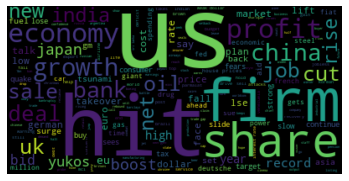

4


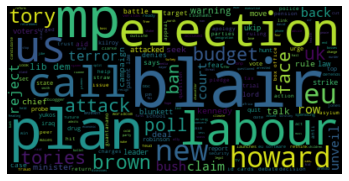

3


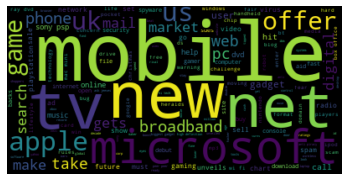

0


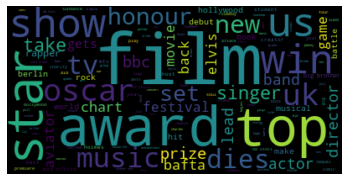

1


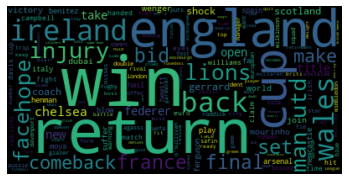

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools

wordcloud = WordCloud(max_words=200,
                      normalize_plurals=True)

print('''=====Lembrete=====\nNossos grupos são:\n- Business\n- Entertainment\n- Politics\n- Sport\n- Tech\n\n''')

for clust in df['assigned_clusters'].unique():
    print(clust)
    df_cat = df.loc[df['assigned_clusters']==clust]['title_clean'].values
    text = ' '.join(list(itertools.chain(*df_cat)))

    plt.imshow(wordcloud.generate(text), interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Usando nossa "colinha", nossos grupos fazem sentido?

In [26]:
from IPython.display import display
for cat in df['category'].unique():
    print(cat)
    display(df.loc[df['category']==cat]['assigned_clusters'].value_counts())

business


2    389
4     76
3     24
1     14
0      7
Name: assigned_clusters, dtype: int64

entertainment


0    305
3     31
4     22
1     16
2     12
Name: assigned_clusters, dtype: int64

politics


4    334
2     42
0     18
3     12
1     11
Name: assigned_clusters, dtype: int64

sport


1    399
4     62
0     27
2     18
3      5
Name: assigned_clusters, dtype: int64

tech


3    294
4     43
2     34
0     23
1      7
Name: assigned_clusters, dtype: int64

-----
# Se estivesssemos classificando, ao invés de agrupando, acertaríamos tudo?
* Random Forest
* 100 árvores
* F-fold cross-validation (10 folds)
* Medida de avaliação: F1

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['category_emb'] = le.fit_transform(df['category'])

In [ ]:
X, y = df['title_emb'].values, df['category_emb']

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

from sklearn.model_selection import cross_val_score
metrics = cross_val_score(clf, list(X), y, scoring='f1_macro', cv=10)

import numpy as np
print('F1', np.mean(metrics))

# O problema é difícil mesmo. Parece que nos saimos bem no agrupamento!
-----
 
 
 
<img src="../data/img/funny.jpg">

<img src="../data/img/theend.jpg">